In [1]:
# !pip install tqdm
# !pip install missingno
# !pip install sklearn
# !pip install matplotlib
# !pip install scipy
# !pip install xgboost
# !pip install typing

[Задание 1](#Задание-1)  
[Задание 2](#Задание-2)  
[Задание 3](#Задание-3)  
[Задание 4](#Задание-4)  
[Задание 5](#Задание-5)  
[Задание 6](#Задание-6)  
[Задание 7](#Задание-7)  

In [2]:
from typing import List, Optional
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import xgboost as xgb
%matplotlib inline

/usr/local/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
train = pd.read_csv('./data/hw1/train.csv')
test = pd.read_csv('./data/hw1/test.csv')

### Задание 1
Сделать базовый анализ данных: вывести размерность датасетов, посчитать базовые статистики, выполнить анализ пропусков, сделать выводы;

In [4]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [5]:
train.shape, test.shape

((200000, 202), (200000, 201))

In [6]:
set(train.columns) - set(test.columns)

{'target'}

In [7]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


**Категориальные признаки**

In [8]:
categorical_features = train.select_dtypes(include=[np.object])
print(f"Categorical Feature Count {categorical_features.shape[1]}")
categorical_features.head(n=2)

Categorical Feature Count 1


,ID_code
0,train_0
1,train_1


In [9]:
len(categorical_features['ID_code'].unique())

200000

ID_code все уникальные, просто ID

**Числовые признаки**

In [10]:
numerical_features = train.select_dtypes(include=[np.number])
print(f"count of numeric_features {numerical_features.shape[1]}")

count of numeric_features 201


Все признаки - числовые. Удобно.

**Дискретные признаки**

In [11]:
discrete_feature = [feature for feature in numerical_features if len(train[feature].unique()) < 25]

print(f"Discrete Variables Count: {len(discrete_feature)}")

Discrete Variables Count: 1


In [12]:
discrete_feature

['target']

Дискретный признак только целевой

In [13]:
train['target'].unique()

array([0, 1])

**Непрерывные признаки**

In [14]:
continuous_feature = [feature for feature in numerical_features if feature not in discrete_feature]

print(f"Continuous Feature Count {len(continuous_feature)}")

Continuous Feature Count 200


**Пропуски**

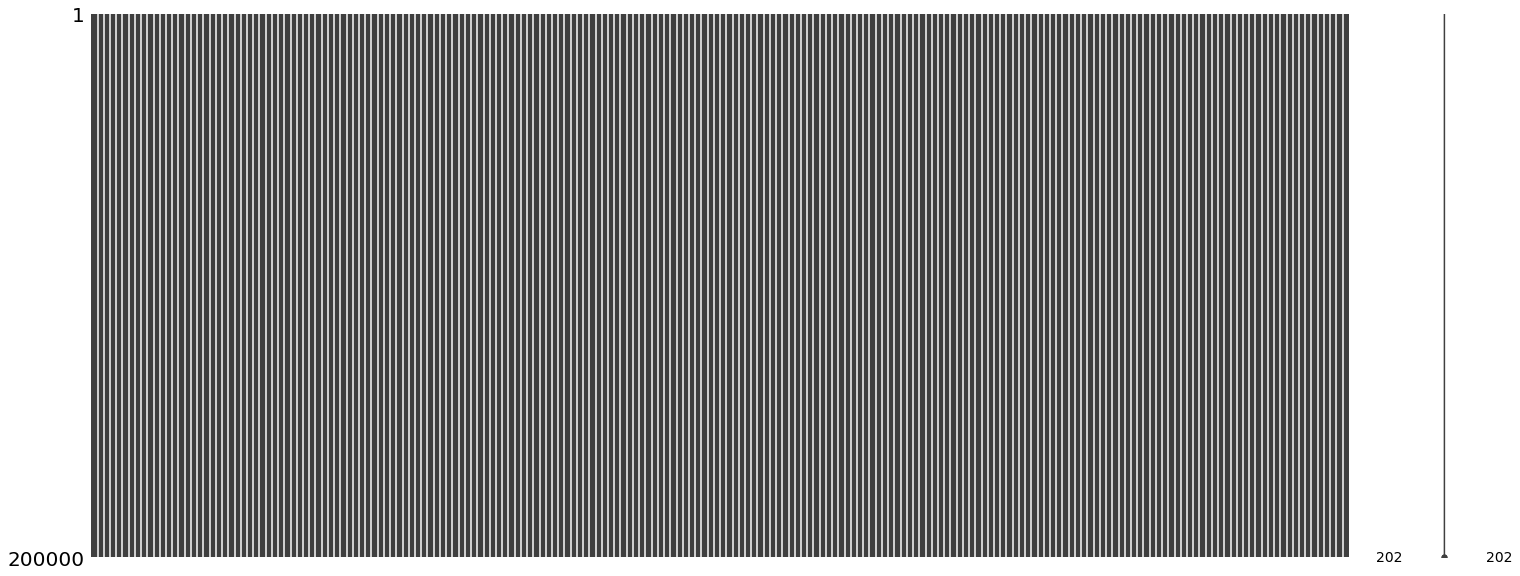

In [15]:
msno.matrix(train);

In [16]:
features_with_na = [
    feature for feature in train.columns
    if train[feature].isnull().sum() > 1]

features_with_na

[]

пропусков нет

### Задание 2
Сделать базовый анализ целевой переменной, сделать выводы;

#### Распределение целевой переменной

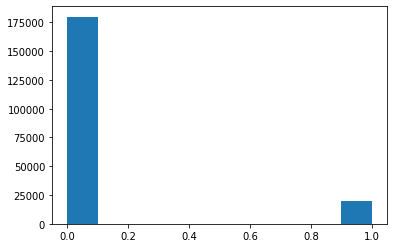

In [17]:
plt.hist(train["target"]);

In [18]:
train["target"].sum()

20098

Сильный перекос в распределении целевой переменной. Так модель может сильно перекосить в сторону 0. Придется как-то балансировать для обучения модели.

### Задание 3
Построить распределение признаков в зависимости от значения целевой переменной и распределение признаков для обучающей и тестовой выборки

**Вопрос:**
У нас нет в test.xls, соответственно в разрезе целевой переменной мы не можем посмотреть. Что имелось ввиду? Надо было разбить test на тест и трейн?

In [19]:
columns = ['var_0', 'var_1', 'var_2', 'var_5', 'var_9', 'var_10', 'var_13', \
           'var_20', 'var_26', 'var_40', 'var_55', 'var_80', 'var_106', 'var_109', \
           'var_139', 'var_175', 'var_184', 'var_196']

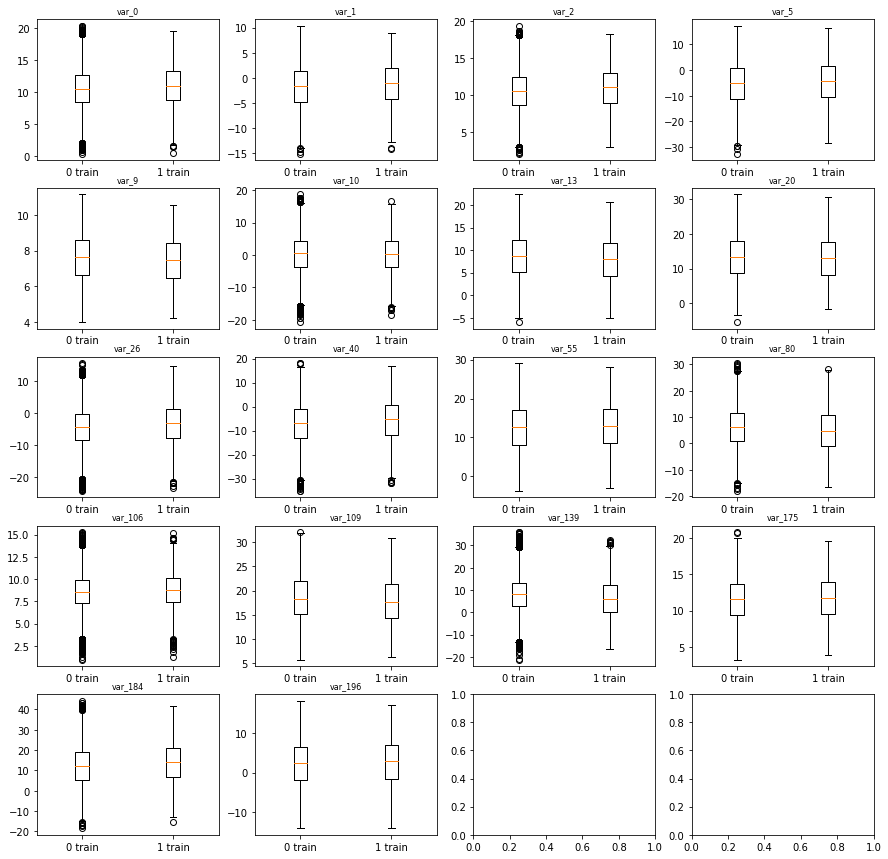

In [20]:
fig, axes = plt.subplots(5, 4, figsize=(15, 15))

for num, feature in enumerate(columns):
    d1 = train[train['target'] == 0][feature]
    d2 = train[train['target'] == 1][feature]
    
    p = axes[num//4, num%4]
    p.boxplot([d1, d2])
    p.set_title(feature, fontsize=8)
    p.set_xticklabels(['0 train', '1 train'])

### Задание 4
Построить распределение основных статистики признаков (среднее, стандартное отклонение) в разрезе целевой переменной и распределение основных статистик обучающей и тестовой выборки

Из прошлого пункта видны эти статистики, или я не так понял задание =/

### Задание 5
Построить распределение коэффициентов корреляции между признаками. Есть ли зависимость между признаками (будем считать, что связь между признаками отсутствует, если коэффициент корреляции < 0.2)?

#### Линейная зависимость

In [21]:
correlation = train.corr()
corr_with_target = correlation["target"].sort_values(ascending = False)
corr_with_target

target     1.000000
var_6      0.066731
var_110    0.064275
var_53     0.063399
var_26     0.062422
             ...   
var_76    -0.061917
var_146   -0.063644
var_12    -0.069489
var_139   -0.074080
var_81    -0.080917
Name: target, Length: 201, dtype: float64

<AxesSubplot:>

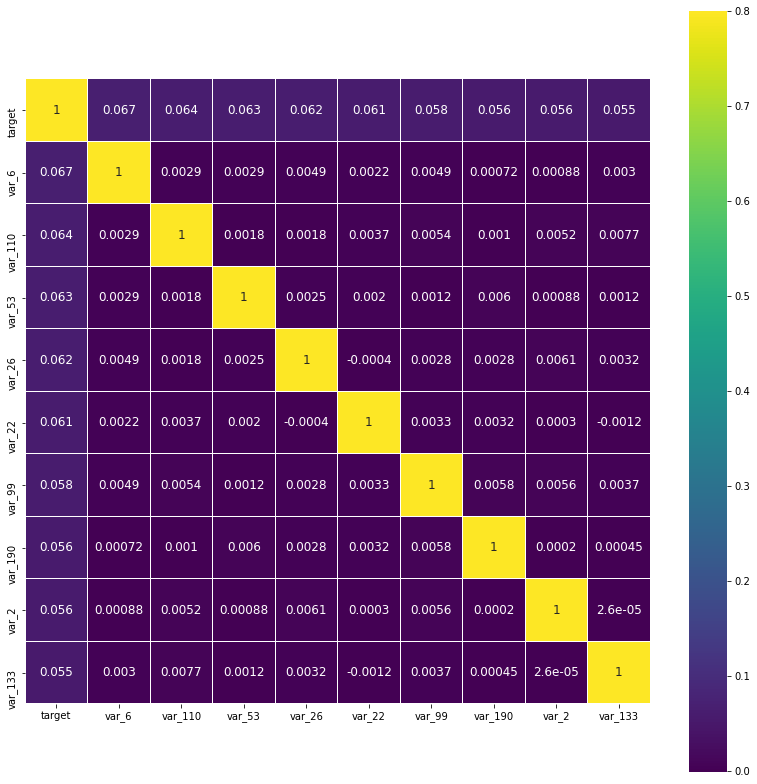

In [22]:
cols = correlation.nlargest(10, "target")["target"].index
cm = np.corrcoef(train[cols].values.T)
fig, axes = plt.subplots(figsize = (14, 14))

sns.heatmap(
    cm,
    vmax=.8,
    linewidths=0.01,
    cmap="viridis",
    square=True,
    annot=True,
    linecolor="white",
    xticklabels=cols.values,
    annot_kws = {"size": 12},
    yticklabels=cols.values
)

Линейной зависимости между признаками не обнаружено

### Задание 6
Выявить 10 признаков, которые обладают наибольшей нелинейной связью с целевой переменной.

#### Нелинейная зависимость

In [23]:
%%time
parameters = {"max_depth": 6, "n_estimators": 25, "random_state": 27, "n_jobs": 2}

forest = RandomForestRegressor(**parameters)
forest.fit(numerical_features.drop("target", axis=1), numerical_features['target'])

CPU times: user 8min 52s, sys: 433 ms, total: 8min 53s
Wall time: 4min 36s


RandomForestRegressor(max_depth=6, n_estimators=25, n_jobs=2, random_state=27)

Text(0.5, 1.0, 'Топ 10 фич по нелинейной кореляции с таргет')

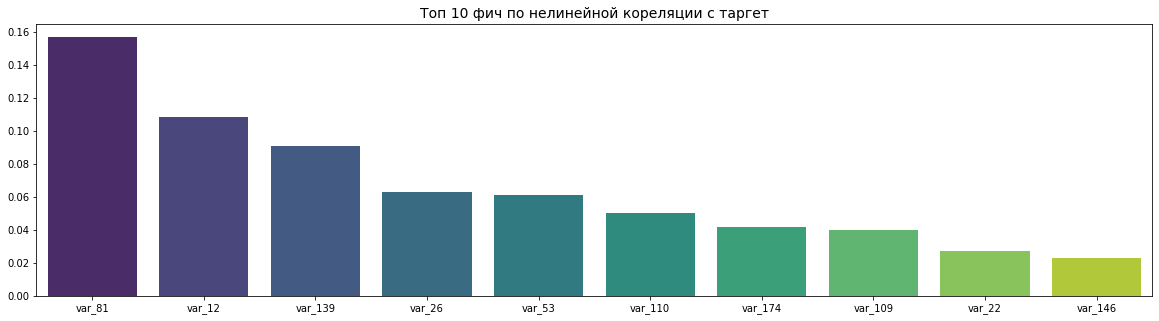

In [30]:
n_top = 10
importances = forest.feature_importances_
idx = np.argsort(importances)[::-1][0:n_top]
feature_names = numerical_features.drop("target", axis=1).columns

plt.figure(figsize=(20, 5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
plt.title(f"Топ {n_top} фич по нелинейной кореляции с таргет", size=14)

### Задание 7
Провести анализ идентичности распределения признаков на обучающей и тестовой выборках, сделать выводы.

**Распределения признаков на трейне и тесте**

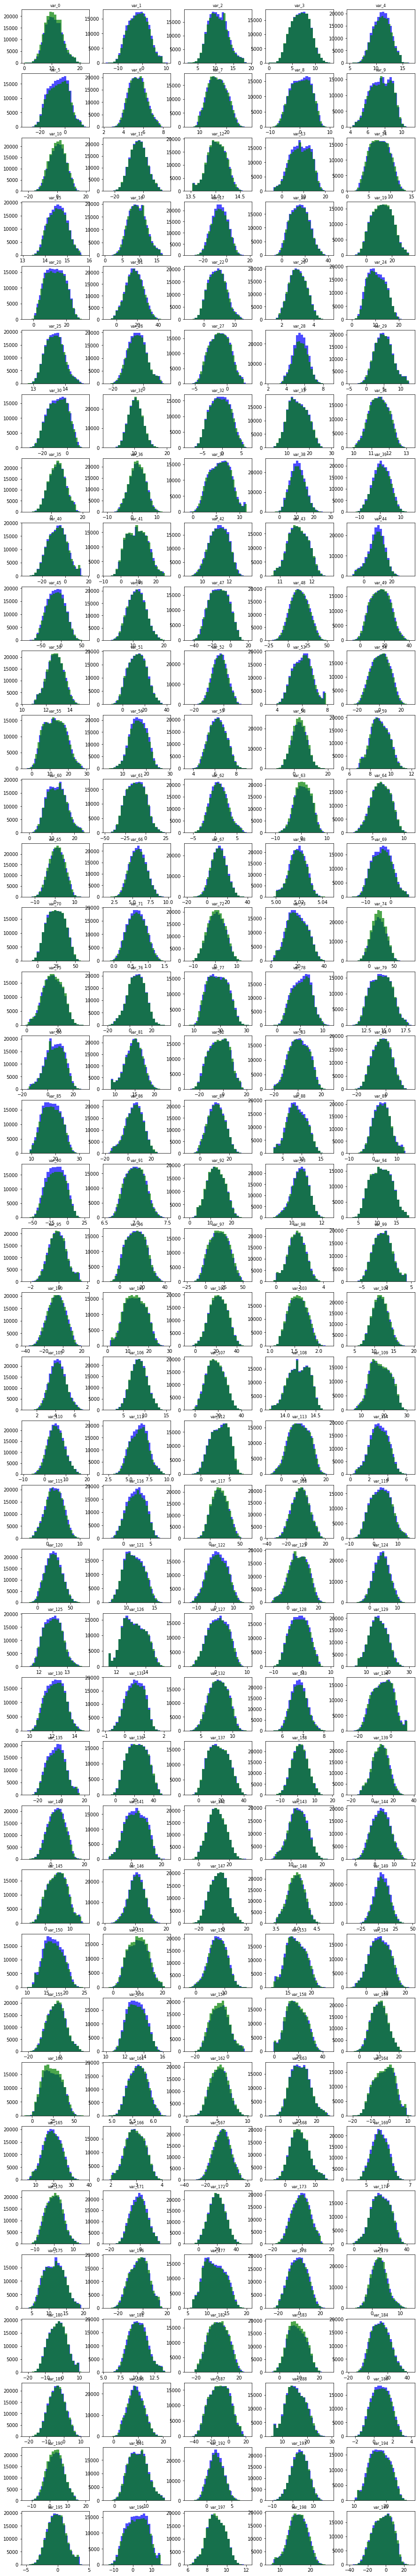

In [25]:
fig, axes = plt.subplots(40, 5, figsize=(15, 100))

for num, feature in enumerate(continuous_feature):
    axes[num//5, num%5].hist(train[feature].copy(), bins=25, color="blue", alpha=0.7)
    axes[num//5, num%5].hist(test[feature].copy(), bins=25, color="green", alpha=0.7)
    axes[num//5, num%5].set_title(feature, fontsize=8)

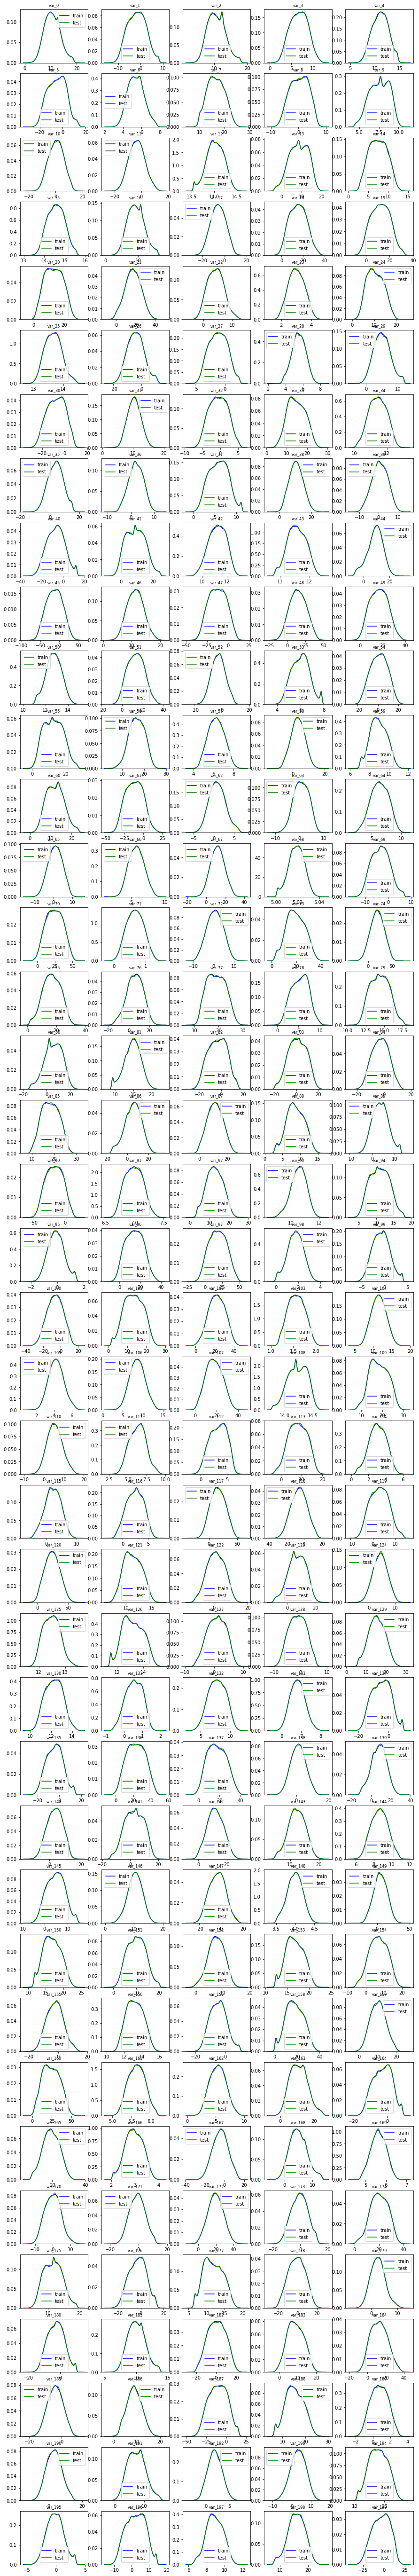

In [26]:
fig, axes = plt.subplots(40, 5, figsize=(15, 100))

for num, feature in enumerate(continuous_feature):
    try:
        train_data, test_data = train[feature].copy(), test[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//5, num%5], color="blue", label="train")
        sns.kdeplot(test_data, ax=axes[num//5, num%5], color="green", label="test")
    except RuntimeError:
        pass
    except KeyError:
        train_data = train[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//5, num%5], color="blue", label="train")
    axes[num//5, num%5].set_title(feature, fontsize=8)

Характер распределений на всех признаках для трейна и теста совпадают.

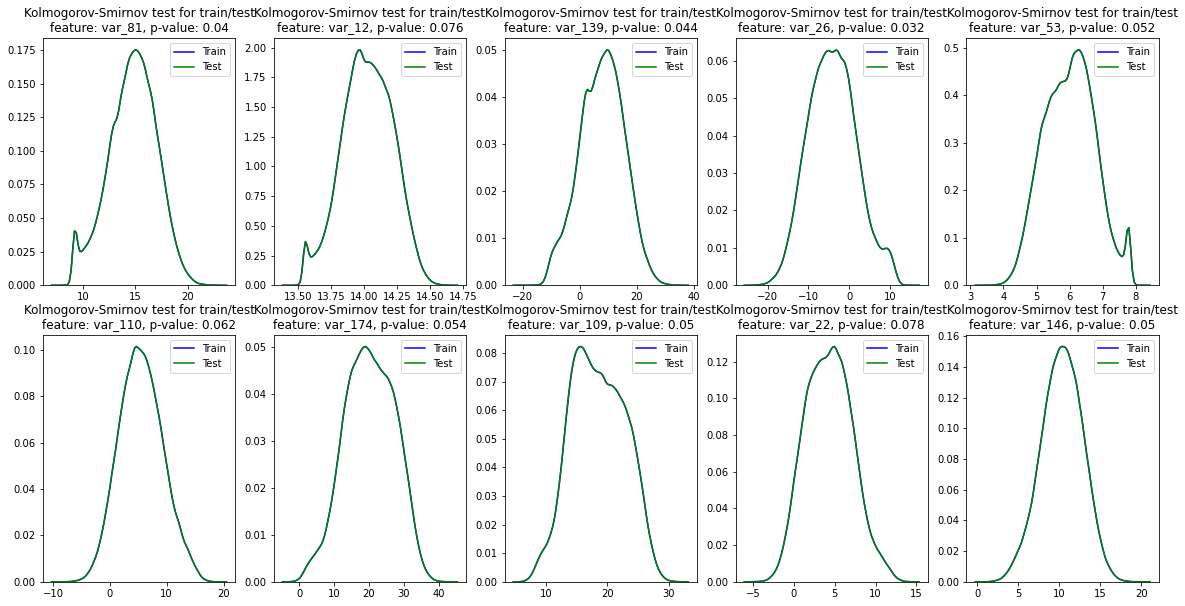

In [27]:
statistics_array = []
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for num, feature in enumerate(feature_names[idx]):
    statistic, pvalue = ks_2samp(
        train[feature].sample(500), test[feature].sample(500)
    )
    statistics_array.append(statistic)

    sns.kdeplot(train[feature], ax=axes[num//5, num%5], color="Blue", label="Train")
    sns.kdeplot(train[feature], ax=axes[num//5, num%5], color="Green", label="Test")

    axes[num//5, num%5].set_title(
        (f"Kolmogorov-Smirnov test for train/test\n"
        f"feature: {feature}, p-value: {round(statistic, 3)}")
    )

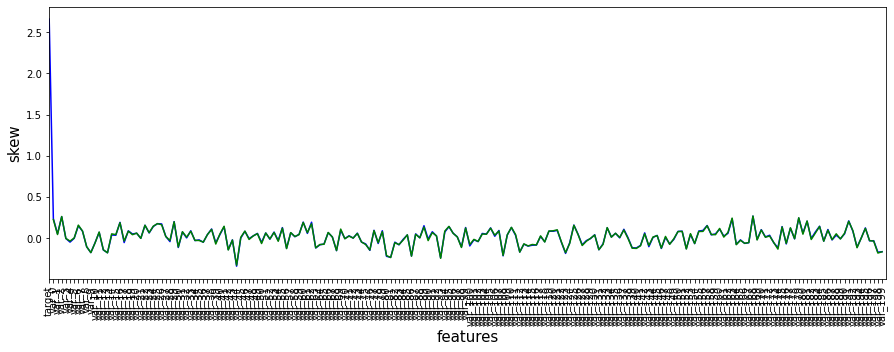

In [28]:
fig = plt.figure(figsize=(15, 5))
train_stats, test_stats = train.skew(), test.skew()
plt.plot(train_stats, color="blue", label="train")
plt.plot(test_stats, color="green", label="test")
plt.xticks(range(train_stats.shape[0]), train_stats.index, rotation=90)
plt.xlabel("features", size=15)
plt.xlim(0, len(train_stats))
plt.ylabel("skew", size=15)
plt.show()

разницы в "перекосе" данных трейна и теста нет

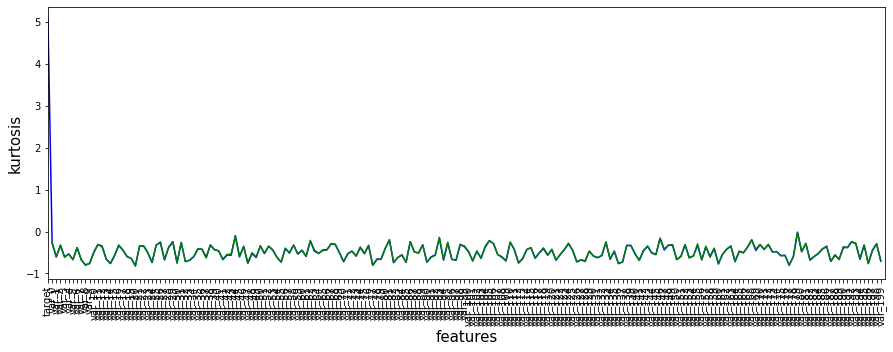

In [29]:
fig = plt.figure(figsize=(15, 5))
train_stats, test_stats = train.kurtosis(), test.kurtosis()
plt.plot(train_stats, color="blue", label="train")
plt.plot(test_stats, color="green", label="test")
plt.xticks(range(train_stats.shape[0]), train_stats.index, rotation=90)
plt.xlabel("features", size=15)
plt.ylabel("kurtosis", size=15)
plt.xlim(0, len(train_stats))
plt.show()

коэффициент эксцесса для фич на трейне и тесте одинаковый